In [549]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from multiprocessing import Pool
from pandas import concat
from pandas import DataFrame
from pandas import set_option
from os import listdir
from os.path import isfile
from time import sleep
from time import time
from random import choice
from pickle import dump
from pickle import load
from warnings import simplefilter
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from numpy import (min max)

set_option('display.max_colwidth',1000)
simplefilter(action='ignore', category=FutureWarning)

%run supported_models/sklRF
%run dataset
%run z3
%run viz_generator

In [543]:
#Data
train, test = download_openml_dataset_split( 'vote', .5 )
ds = test

#Random Forest
parameters = {'min_samples_leaf':[2],'n_estimators':[20]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=10)
clf = clf.fit(train.data, train.target)

#Logic Objects
RF = SciKitLearnRF(clf.best_estimator_,train)
engine = Z3(train,RF) #compute bounds over all data, but classifer has never seen test

#Find the samples where the RF is incorrect
predictions = clf.predict(test.data)
incorrect = []
for i in range(len(predictions)):
    if predictions[i]!=test.target[i]:
        print('Row%d:\t'%i,'target=%d'%test.targetMap[test.target[i]], 'output=%d'%test.targetMap[predictions[i]])
        incorrect.append(i)

Row4:	 target=0 output=1
Row38:	 target=1 output=0
Row42:	 target=0 output=1
Row88:	 target=0 output=1
Row100:	 target=0 output=1
Row117:	 target=1 output=0
Row189:	 target=0 output=1
Row191:	 target=0 output=1


# Why does the model disagree with the ground truth label?

In [544]:
MUCs=[]
for idx in incorrect:
    print(idx)
    MUCs.append(get_explanation(idx,predictions[idx]))

4
38
42
88
100
117
189
191


In [1]:
# Create a table of explanations for writeup
explanations=[]
for MUC in MUCs:
    explanations.append(rationalize_behavior_by_category(MUC,test,predictions,vote_dictionary))

rationalization = {'Test ID':[i for i in incorrect],
                   'Ground Truth':[test.targetMap[test.target[i]].upper()[1:4] for i in incorrect],
                   'Model Output':[test.targetMap[clf.predict(test.data)[i]].upper()[1:4] for i in incorrect],
                   'Attribute Values':[explanations[i]['input'] if type(explanations[i])==dict else '' for i in range(len(incorrect)) ],
                   'Threshold Values':[explanations[i]['threshold'] if type(explanations[i])==dict else '' for i in range(len(incorrect)) ],
                   'Leaf Assignments':[explanations[i]['leaf'] if type(explanations[i])==dict else '' for i in range(len(incorrect)) ]
                  }
explanation_df = DataFrame(data=rationalization)
# print(explanation_df.to_latex(index=False))

NameError: name 'MUCs' is not defined

# What can we do to change the model?

In [414]:
num_processors = 20
p=Pool(processes = num_processors)
output = p.map(get_interventions ,[i for i in incorrect])
p.close()
with open('interventions.pkl','wb') as f:
    dump(output, f)

Process ForkPoolWorker-1726:
Process ForkPoolWorker-1735:
Process ForkPoolWorker-1729:
Process ForkPoolWorker-1731:
Process ForkPoolWorker-1730:
Process ForkPoolWorker-1736:
Process ForkPoolWorker-1721:
Process ForkPoolWorker-1724:


KeyboardInterrupt: 

Process ForkPoolWorker-1733:
Process ForkPoolWorker-1732:
Process ForkPoolWorker-1728:
Process ForkPoolWorker-1727:
Process ForkPoolWorker-1737:
Process ForkPoolWorker-1725:
Process ForkPoolWorker-1740:
Process ForkPoolWorker-1723:
Process ForkPoolWorker-1739:
Process ForkPoolWorker-1734:
Process ForkPoolWorker-1738:
Traceback (most recent call last):
  File "/zfsauton/home/ngisolfi/anaconda2/envs/p3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/zfsauton/home/ngisolfi/anaconda2/envs/p3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/zfsauton/home/ngisolfi/anaconda2/envs/p3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/zfsauton/home/ngisolfi/anaconda2/envs/p3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-267-85eb8079

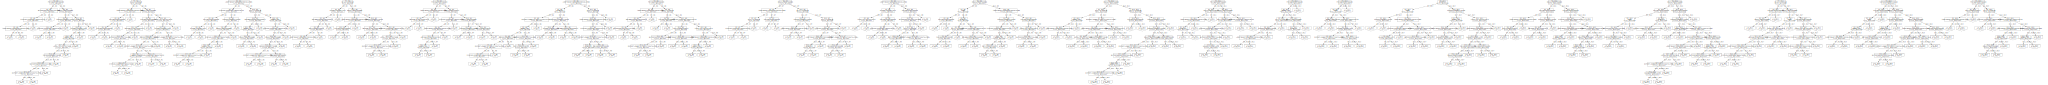

In [557]:
dot = Digraph(comment='SAT Model',graph_attr={'splines':'spline'})#{'splines':'ortho'})
models = viz_rf(engine.assert_branches(),engine.assert_rules(),engine.assert_leaves(),[],[])#interventions,changes)
dot.subgraph(models)
dot.render('intervention_tree', view=True)

# When should we not trust model output?

In [199]:
cD=get_distrust_regions()

confusing = DataFrame(columns=train.data.columns)
for elem in cD:
    confusing = confusing.append([elem])


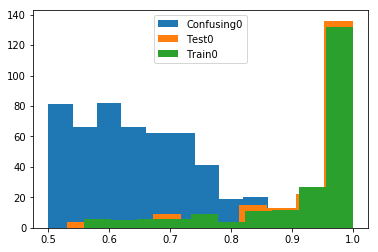

In [201]:
# *** Show the random forest's confidence (Low for confusing samples)
trainprobs = clf.best_estimator_.predict_proba(train.data)
trainprobs = [max(trainprobs[i]) for i in range(len(trainprobs))]

testprobs = clf.best_estimator_.predict_proba(test.data)
testprobs = [max(testprobs[i]) for i in range(len(testprobs))]

confusingprobs = clf.best_estimator_.predict_proba(confusing)
confusingprobs = [max(confusingprobs[i]) for i in range(len(confusingprobs))]

plt.figure()
plt.hist(confusingprobs,label=('Confusing0'))
plt.hist(testprobs,label=('Test0'))
plt.hist(trainprobs,label=('Train0'))
plt.legend(loc='upper center')

# *** Show the individual trees confidence (High for confusing samples) ***
# for modelID in range(10):
#     trainprobs = clf.best_estimator_.estimators_[modelID].predict_proba(train.data)
#     trainprobs = [max(trainprobs[i]) for i in range(len(trainprobs))]

#     testprobs = clf.best_estimator_.estimators_[modelID].predict_proba(test.data)
#     testprobs = [max(testprobs[i]) for i in range(len(testprobs))]

#     confusingprobs = clf.best_estimator_.estimators_[modelID].predict_proba(confusing)
#     confusingprobs = [max(confusingprobs[i]) for i in range(len(confusingprobs))]

#     plt.figure()
#     plt.hist(confusingprobs,label=('Confusing0'))
#     plt.hist(testprobs,label=('Test0'))
#     plt.hist(trainprobs,label=('Train0'))
#     plt.legend(loc='upper center')

Computing t-SNE embedding


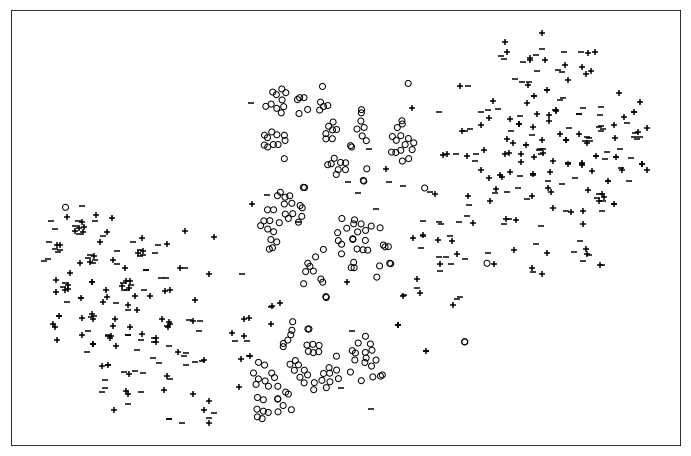

In [243]:
xtrain = train.data
ytrain = [0 for elem in train.target]
xtest = test.data
ytest = [1 for elem in test.target]
xconfusing = confusing[:220]
yconfusing = [2 for elem in range(220)]

xall = concat([xtrain,xtest,xconfusing])
yall = ytrain+ytest+yconfusing

X=xall
y=yall
n_samples, n_features = X.shape
n_neighbors = 100

# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig=plt.figure(figsize=(12, 8),frameon=False)
    #ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.scatter(X[i,0],X[i,1],marker=['+','_','o'][y[i]],color='black',facecolors=['black','black','none'][y[i]])#['black','black','white'][y[i]])

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title,fontdict={'fontsize':14,})
    fig.savefig('tsne_3.pdf', format='pdf',bbox_inches='tight', pad_inches=0)

print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca',random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)


### Experiment Scripts

In [460]:
def get_explanation( rowID, yhat ):
    query={}
    for attnum in range(len(ds.data.columns)):
        query[ds.data.columns[attnum]]=ds.data.iloc[rowID][attnum]

    scriptText = \
        engine.set_options_true(['produce-models',
                                 'produce-unsat-cores',
                                 'smt.core.minimize']) + \
        engine.set_logic('AUFLIRA') + \
        engine.declare_query_attribute_values() + \
        engine.assert_query_attribute_values(query)+ \
        engine.declare_query_target() + \
        engine.assert_query_target(ds.target[rowID]) + \
        engine.declare_ensemble_prediction_array() + \
        engine.declare_thresholds() + \
        engine.assert_thresholds() + \
        engine.declare_rules() + \
        engine.assert_rules() + \
        engine.declare_branches() + \
        engine.assert_branches() + \
        engine.declare_predictions() + \
        engine.assert_leaves() + \
        engine.assert_ensemble_prediction_array()

    for i in range(len(engine.dataSet.targetMap)):
        scriptText += engine.declare_function_count_key_in_array(i)
        scriptText += engine.assert_function_count_key_in_array(i)

    scriptText += \
        engine.declare_ensemble_prediction_votes() + \
        engine.assert_ensemble_prediction_votes() + \
        engine.declare_function_max_of_array() + \
        engine.assert_function_max_of_array() + \
        engine.declare_human_expectation_for_query_target() + \
        engine.assert_human_expectation_for_query_target(ds.target[rowID]) + \
        engine.conclude()

    filename = 'output/why_not_row%d_prediction'%(rowID)
    script2file(filename,scriptText)
    run_z3_script( filename, '.model' )    
    
    # Minimize Unsat Core
    origUnsatCore=load_unsat_core(filename+'.model')
    if '(define-fun' in origUnsatCore:
        return rowID, {'model':'SAT'}
    unsatMarks = {atom:False for atom in origUnsatCore}
    
    # Multiprocess unsat hypotheses
    num_processors = 40
    p=Pool(processes = num_processors)
    output = p.map(minimize_unsat_core ,[(rowID,scriptText,key,yhat,ds.target[rowID]) for key in unsatMarks])
    p.close()

    output = [x for x in output if x is not None]
    
    return rowID, output


In [534]:
def minimize_unsat_core(obj):
        rowID=obj[0]
        scriptText = obj[1]
        key = obj[2]
        yhat=obj[3]
        y=obj[4]
        newScript = []
        for line in scriptText:
            if key in line:
                newScript.append(';'+line)
            else:
                newScript.append(line)

        filename = 'output/why_not_row%d_unsat_%s'%(rowID,key)
        script2file(filename,newScript)
        run_z3_script( filename, '.model' )
        currUnsatCore = load_unsat_core('./'+filename+'.model')
        if '(define-fun' in currUnsatCore:
            return key
        return

In [ ]:
def get_interventions( rowID ):
    
    query={}
    for attnum in range(len(ds.data.columns)):
        query[ds.data.columns[attnum]]=ds.data.iloc[rowID][attnum]

        scriptText = \
        engine.set_options_true(['produce-models',
                                 'produce-unsat-cores',
                                 'smt.core.minimize']) + \
        engine.set_logic('AUFLIRA') + \
        engine.declare_query_attribute_values() + \
        engine.assert_query_attribute_values(query)+ \
        engine.declare_query_target() + \
        engine.assert_query_target(ds.target[rowID]) + \
        engine.declare_ensemble_prediction_array() + \
        engine.declare_thresholds() + \
        engine.assert_thresholds() + \
        engine.declare_rules() + \
        engine.assert_rules() + \
        engine.declare_branches() + \
        engine.assert_branches() + \
        engine.declare_predictions() + \
        engine.assert_leaves() + \
        engine.assert_ensemble_prediction_array()

    for i in range(len(engine.dataSet.targetMap)):
        scriptText += engine.declare_function_count_key_in_array(i)
        scriptText += engine.assert_function_count_key_in_array(i)

    scriptText += \
        engine.declare_ensemble_prediction_votes() + \
        engine.assert_ensemble_prediction_votes() + \
        engine.declare_function_max_of_array() + \
        engine.assert_function_max_of_array() + \
        engine.conclude()        
        
        
    basefile = 'output/intervention_row%d_base_model'%(rowID)
    script2file(basefile,scriptText)
    run_z3_script( basefile, '.model' )
        
    interventionScriptText = \
        engine.set_options_true(['produce-models',
                                 'produce-unsat-cores',
                                 'smt.core.minimize']) + \
        engine.set_logic('AUFLIRA') + \
        engine.declare_query_attribute_values() + \
        engine.assert_query_attribute_values(query)+ \
        engine.declare_query_target() + \
        engine.assert_query_target(ds.target[rowID]) + \
        engine.declare_ensemble_prediction_array() + \
        engine.dataSet.declare_training_data() + \
        engine.dataSet.assert_training_data() + \
        engine.dataSet.declare_training_targets() + \
        engine.dataSet.assert_training_targets() + \
        engine.declare_thresholds() + \
        engine.soft_assert_atomic_constraints('thresholdAssertions') + \
        engine.declare_rules() + \
        engine.assert_rules() + \
        engine.declare_branches() + \
        engine.assert_branches() + \
        engine.declare_predictions() + \
        engine.assert_leaves() + \
        engine.model.modelAsFunctions + \
        engine.get_training_predictions_from_each_model() + \
        engine.declare_training_votes() + \
        engine.assert_training_votes() + \
        engine.declare_consensus_functions_for_training_data() + \
        engine.evaluate_consensus_functions_for_training_data() + \
        engine.reach_consensus_for_training_data() + \
        engine.collect_train_data_predictions() + \
        engine.count_correct_training_data_predictions() + \
        engine.assert_no_loss_of_train_accuracy(clf.score(train.data,train.target)) + \
        engine.assert_ensemble_prediction_array()
    
    for i in range(len(engine.dataSet.targetMap)):
        interventionScriptText += engine.declare_function_count_key_in_array(i)
        interventionScriptText += engine.assert_function_count_key_in_array(i)

    interventionScriptText += \
        engine.declare_ensemble_prediction_votes() + \
        engine.assert_ensemble_prediction_votes() + \
        engine.declare_function_max_of_array() + \
        engine.assert_function_max_of_array() + \
        engine.declare_human_expectation_for_query_target() + \
        engine.assert_human_expectation_for_query_target(ds.target[rowID]) + \
        engine.conclude()

    softfile = 'output/intervention_row%d_soft_model'%(rowID)
    script2file(softfile,interventionScriptText)
    run_z3_script( softfile, '.model' )

    base_model=load_sat_model(basefile+'.model')
    soft_model= load_sat_model(softfile+'.model')
    
    interventions = {}
    changes= {}
    for key in base_model.keys():
        if key[0].isupper():
            continue
        if key[0]=='b' or key[0]=='r':
            if base_model[key]!=soft_model[key]:
                changes[key]=[base_model[key],soft_model[key]]
        if base_model[key]!=soft_model[key]:
            interventions[key]=[base_model[key],soft_model[key]]
            changes[key]=[base_model[key],soft_model[key]]

    return rowID, interventions,changes


In [262]:
def get_distrust_regions( confusingAssertions=[], confusingData=[] ):

    scriptText = \
        engine.set_options_true(['produce-models',
                                 'produce-unsat-cores',
                                 'smt.core.minimize']) + \
        engine.set_logic('AUFLIRA') + \
        engine.declare_query_attribute_values() + \
        engine.declare_ensemble_prediction_array() + \
        engine.assert_query_binary_search_bounds() + \
        engine.declare_thresholds() + \
        engine.assert_thresholds() + \
        engine.declare_rules() + \
        engine.assert_rules() + \
        engine.declare_branches() + \
        engine.assert_branches() + \
        engine.declare_predictions() + \
        engine.assert_leaves() + \
        engine.assert_ensemble_prediction_array()

    for i in range(len(engine.dataSet.targetMap)):
        scriptText += engine.declare_function_count_key_in_array(i)
        scriptText += engine.assert_function_count_key_in_array(i)

    scriptText += \
        engine.declare_ensemble_prediction_votes() + \
        engine.assert_ensemble_prediction_votes() + \
        engine.declare_function_max_of_array() + \
        engine.assert_function_max_of_array() + \
        engine.assert_maximal_confusion()

    for idx in range(len(confusingAssertions)):
        scriptText += [confusingAssertions[idx]]

    scriptText += \
        engine.conclude()

    filename = 'output/confusing_%d'%(len(confusingData))

    script2file(filename,scriptText)
    run_z3_script( filename, '.model' )

    satModel = load_sat_model(filename+'.model')
    confusingQuery = get_query_from_SAT_model(satModel, ds)
    confusingAssertions.append(remove_query_from_solution_set(confusingQuery,len(confusingData)))
    confusingData.append(confusingQuery)
    if(len(confusingData)<500):
        get_distrust_regions(confusingAssertions,confusingData)
    else:
        return confusingData

    return confusingData

In [454]:
def rationalize_behavior_by_category( reasoning, ds, model_predictions, domain_dict ):
    rowID = reasoning[0]
    atoms = reasoning[1]
    leaf_atoms = [elem.replace('-L','L') for elem in atoms if '-L' in elem]
    threshold_atoms = [elem.replace('-T','T')  for elem in atoms if '-T' in elem]
    machine_atoms = [elem for elem in atoms if 'MACHINE' or 'GROUNDTRUTH' in elem]
    input_atoms = [elem.replace('EQUALS','=') for elem in atoms if 'EQUALS' in elem]

    return {'input':input_atoms, 'threshold':threshold_atoms, 'leaf':leaf_atoms, 'machine':machine_atoms}
